In [491]:
import cv2
import numpy as np
import math
import matplotlib.pyplot as plt
from skimage import io, color

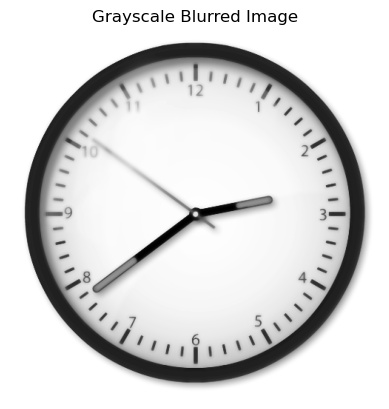

In [532]:
image = io.imread('ceas4.png')
L,C,pl =  np.shape(image)
if pl>3:
    image = image[:,:,0:3]

# TODO: Add more images for tests
# TODO: Add a test method to iterate through them to check the accuracy of the algorithm
# TODO: Extract the functionalities here in a separate class (maybe clock_detector.py > AnalogClockDetector)

if image.dtype != np.uint8:
    # Scalează valorile pixelilor la intervalul [0, 255] și convertește la uint8
    image = (image * 255).astype(np.uint8)
    
# TODO: Scale the image to a fixed size for every image and change (high priority)
# Dimensiuni dorite pentru scalare
TARGET_WIDTH = 500  # Lățimea dorită
TARGET_HEIGHT = 500  # Înălțimea dorită

# Scalează imaginea la dimensiunile fixe
image = cv2.resize(image, (TARGET_WIDTH, TARGET_HEIGHT), interpolation=cv2.INTER_AREA)
# the HoughCircles and HoughLines min and max distances for best performance

# Convertim imaginea în grayscale dacă este color
if len(image.shape) == 3:  # Verifică dacă imaginea este RGB
    image_gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
else:
    image_gray = image
# TODO: Search for a better filter, maybe bilateral and change for better detections
#blurred = cv2.GaussianBlur(gray, (9, 9), 0)
blurred = cv2.bilateralFilter(image_gray, d=9, sigmaColor=75, sigmaSpace=75)

plt.imshow(blurred, cmap='gray')
plt.title("Grayscale Blurred Image")
plt.axis('off')
plt.show()


248 248 229


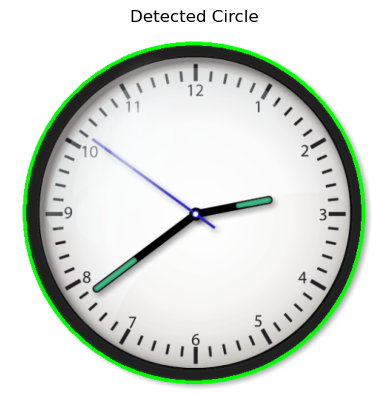

In [533]:
circles = cv2.HoughCircles(blurred, cv2.HOUGH_GRADIENT, dp=0.8, minDist=1000, param1=50, param2=30, minRadius=100, maxRadius=500)

if circles is not None:
    circles = np.round(circles[0, :]).astype("int")
    for (x, y, r) in circles:
        print(x,y,r)
        cv2.circle(image, (x, y), r, (0, 255, 0), 4)
        center = (x, y)
        radius = r
else:
    raise Exception("No circles were found.")

plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title("Detected Circle")
plt.axis('off')
plt.show()


In [534]:
def merge_lines(lines, threshold_distance=20, threshold_angle=np.pi / 18):
    """
    Funcție pentru unirea liniilor detectate cu HoughLinesP.
    
    Parametri:
    - lines: Lista de linii detectate sub forma [[[x1, y1, x2, y2]], ...].
    - threshold_distance: Distanța maximă între capetele liniilor pentru a le combina.
    - threshold_angle: Diferența maximă de unghi între linii pentru a le combina (în radiani).

    Returnează:
    - Lista de linii unite.
    """
    def calculate_angle(line):
        x1, y1, x2, y2 = line
        return np.arctan2(y2 - y1, x2 - x1)

    def are_lines_similar(line1, line2):
        angle1 = calculate_angle(line1)
        angle2 = calculate_angle(line2)
        # Distanța minimă între capetele liniilor
        dist1 = np.linalg.norm(np.array(line1[:2]) - np.array(line2[:2]))
        dist2 = np.linalg.norm(np.array(line1[2:]) - np.array(line2[2:]))
        dist3 = np.linalg.norm(np.array(line1[:2]) - np.array(line2[2:]))
        dist4 = np.linalg.norm(np.array(line1[2:]) - np.array(line2[:2]))
        return (abs(angle1 - angle2) < threshold_angle and
                min(dist1, dist2, dist3, dist4) < threshold_distance)

    merged_lines = []
    used = set()

    for i, line1 in enumerate(lines):
        if i in used:
            continue
        x1, y1, x2, y2 = line1[0]
        for j, line2 in enumerate(lines):
            if i == j or j in used:
                continue
            if are_lines_similar(line1[0], line2[0]):
                x1 = (line1[0][0] + line2[0][0]) // 2
                y1 = (line1[0][1] + line2[0][1]) // 2
                x2 = (line1[0][2] + line2[0][2]) // 2
                y2 = (line1[0][3] + line2[0][3]) // 2
                used.add(j)
        merged_lines.append([[x1, y1, x2, y2]])

    return merged_lines


In [535]:
def normalize_line_orientation(line, center):
    """
    Reordonează coordonatele unei linii astfel încât capătul mai apropiat de centru să fie primul.
    
    Parametri:
    - line: Coordonatele liniei sub forma (x1, y1, x2, y2).
    - center: Coordonatele centrului (cx, cy).
    
    Returnează:
    - Linia reordonată sub forma (x1, y1, x2, y2).
    """
    x1, y1, x2, y2 = line
    distance1 = math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2)
    distance2 = math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2)
    print(f"Distance 1 is: {distance1}")
    print(f"Distance 2 is: {distance2}")
    if distance2 < distance1 or distance2-distance1<15:
        # Dacă al doilea capăt este mai aproape de centru, inversăm linia
        return x2, y2, x1, y1
        print(f"Linie inversata: {line}")
    return x1, y1, x2, y2


In [536]:
def is_line_on_circle(line, center, radius, tolerance=50):
    """
    Verifică dacă o linie este pe conturul cercului.
    
    Parametri:
    - line: Coordonatele liniei (x1, y1, x2, y2).
    - center: Centrul cercului (cx, cy).
    - radius: Raza cercului.
    - tolerance: Toleranța în pixeli față de raza cercului.

    Returnează:
    - True dacă linia este pe conturul cercului, False altfel.
    """
    x1, y1, x2, y2 = line
    dist1 = math.sqrt((x1 - center[0]) ** 2 + (y1 - center[1]) ** 2)
    dist2 = math.sqrt((x2 - center[0]) ** 2 + (y2 - center[1]) ** 2)

    # Verifică dacă ambele capete sunt aproape de circumferința cercului
    return (abs(dist1 - radius) < tolerance and abs(dist2 - radius) < tolerance)


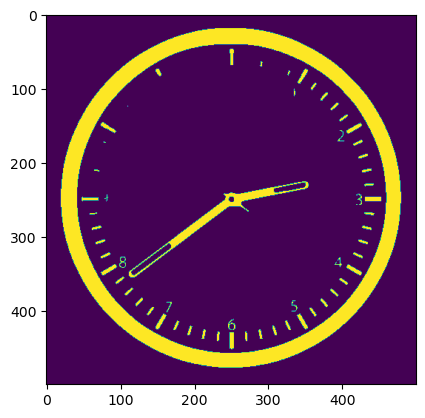

Yes
[[38, 336, 161, 459]]
Distance 1 is: 227.69277546729498
Distance 2 is: 228.23233776132602
161 459 38 336
Yes
[[153, 319, 270, 241]]
Distance 1 is: 118.6001686339442
Distance 2 is: 23.08679276123039
270 241 153 319
140.61649974309557
[[40, 153, 154, 39]]
Distance 1 is: 228.66788143506292
Distance 2 is: 229.16587878652442
154 39 40 153
Yes
[[345, 456, 457, 343]]
Distance 1 is: 229.5059912072014
Distance 2 is: 229.57787349829687
457 343 345 456
Yes
[[342, 38, 459, 155]]
Distance 1 is: 230.07824755939012
Distance 2 is: 230.58620947489467
459 155 342 38
Yes
[[63, 362, 147, 453]]
Distance 1 is: 217.30393461693234
Distance 2 is: 228.53008554673934
147 453 63 362
Yes
[[22, 270, 105, 426]]
Distance 1 is: 227.06827167175956
Distance 2 is: 228.32652057962954
105 426 22 270
Yes
[[229, 20, 394, 70]]
Distance 1 is: 228.79029699705362
Distance 2 is: 230.21728866442677
394 70 229 20
Yes
[[131, 336, 256, 243]]
Distance 1 is: 146.40013661195812
Distance 2 is: 9.433981132056603
256 243 131 336
155.80

In [537]:
_, thresholded = cv2.threshold(blurred, 120, 255, cv2.THRESH_BINARY_INV)
plt.figure(), plt.imshow(thresholded), plt.show()
lines = cv2.HoughLinesP(thresholded, 1, np.pi / 180, 100, minLineLength=radius // 3, maxLineGap=10)

# TODO: Add a merging lines method and use it here (high priority)
# (https://stackoverflow.com/questions/45531074/how-to-merge-lines-after-houghlinesp)

# Separate lines into potential hour and minute hands based on length
if lines is not None:
    print("Yes")
     # Unim liniile detectate
    lines = merge_lines(lines)
    hour_hand = None
    minute_hand = None
    max_length = 0
    max_length_hour =0 
    max_coord=0
    for line in lines:
        print(line)
        for x1, y1, x2, y2 in line:
            #Normalizează linia pentru a avea capătul mai apropiat de centru primul
            x1, y1, x2, y2 = normalize_line_orientation((x1, y1, x2, y2), center)
            print(x1, y1, x2, y2)
             # Exclude liniile aflate pe conturul cercului
            if is_line_on_circle((x1, y1, x2, y2), center, radius):
                print("Yes")
                continue  # Treci la următoarea linie
                
            length = math.sqrt((x2 - x1) ** 2 + (y2 - y1) ** 2)
            if length > max_length:
                if max_coord!=0:
                    hour_hand=max_coord
                max_coord=(x1,y1,x2,y2)
                max_length = length
                print(max_length)
                minute_hand = (x1, y1, x2, y2)  
            elif hour_hand is None or (length < max_length and length>max_length_hour) :
                hour_hand = (x1, y1, x2, y2)
print(f"Hour hand is {hour_hand}")
print(f"Minute hand is{minute_hand}")

In [538]:
def calculate_angle(line, center):
    x1, y1, x2, y2 = line
    dx, dy = x2 - center[0], center[1] - y2
    angle = math.degrees(math.atan2(dy, dx))

    angle = (90 - angle) % 360
    return angle

minute_angle = calculate_angle(minute_hand, center)
hour_angle = calculate_angle(hour_hand, center)

minute = round(minute_angle / 6)%60 # Each minute represents 6 degrees
hour = round(hour_angle / 30) % 12  # Each hour represents 30 degrees

print(f"Detected Time: {hour}:{minute:02d}")

Detected Time: 3:39


237 252 351 230
256 243 131 336


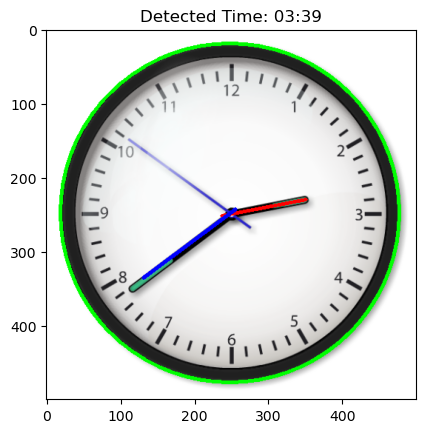

In [539]:
if hour_hand is not None:
    print(hour_hand[0], hour_hand[1], hour_hand[2], hour_hand[3])
    cv2.line(image, (hour_hand[0], hour_hand[1]), (hour_hand[2], hour_hand[3]), (0, 0, 255), 3)

if minute_hand is not None:
    print(minute_hand[0], minute_hand[1], minute_hand[2], minute_hand[3])
    cv2.line(image, (minute_hand[0], minute_hand[1]), (minute_hand[2], minute_hand[3]), (255, 0, 0), 3)

plt.figure(), plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
plt.title(f"Detected Time: {hour:02d}:{minute:02d}")
#plt.axis('off')
plt.show()